In [1]:
import kagglehub
purusinghvi_email_spam_classification_dataset_path = kagglehub.dataset_download('purusinghvi/email-spam-classification-dataset')

print('Data source import complete.')

Data source import complete.


# Preprocess the data

In [2]:
#Import library
#Data preprocessing
import numpy as np # linear algebra
import pandas as pd # data processing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
import re

#Visualization
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

#Feature Engineering
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

#Machine Learning Model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Dropout,Activation,Bidirectional
import tensorflow as tf

#Evaluation Metric
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
#Load the dataset
df=pd.read_csv("/kaggle/input/email-spam-classification-dataset/combined_data.csv")
df.head(5)

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In this dataset:
* '1' indicates that the email is classified as spam.
* '0' denotes that the email is legitimate (ham).

**Check for missing value**

In [4]:
print(df.isnull().sum())

label    0
text     0
dtype: int64


**Check the shape of the data**

In [5]:
df.shape

(83448, 2)

**Convert to lower case letter**

In [6]:
df['text'] = df['text'].str.lower()

**Remove Numbers and Special Character**

Often, characters, symbols, and numbers usually don't contribute to differentiating spam from legitimate emails.

In [7]:
def remove_special_characters(word):
    return word.translate(str.maketrans('', '', string.punctuation))
df['text'] = df['text'].apply(remove_special_characters)

**Remove English stop-words**

Stopwords e like ‘the’, ‘a’,.... can be removed from the text because they don’t provide valuable information.

In [8]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
#Define stop-words in English
ENGLISH_STOP_WORDS = set(stopwords.words('english'))

def remove_stop_words(words):
    return [word for word in words if word not in ENGLISH_STOP_WORDS]

#Tokenize the text
df['text'] = df['text'].apply(word_tokenize)

#Remove stop words
df['text'] = df['text'].apply(remove_stop_words)

#Rejoin words for EDA
df['text'] = df['text'].apply(' '.join)

**Removal of hyperlinks**

Some emails contains URL which doesn't provide any valuable information.

In [10]:
def remove_hyperlink(word):
    return re.sub(r"http\S+", "", word)

df['text'] = df['text'].apply(remove_hyperlink)

# Exploratory Data Analysis

**Let check with an example of a spam text**


In [11]:
for i in range (1,3):
    print("Email #"+str(i))
    spam_email = df[df['label'] == 1]['text'].iloc[i]
    print(spam_email+"\n")

Email #1
wulvob get medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumber escapenumber cialis escapenumber escapenumber imitrex escapenumber escapenumber flonax escapenumber escapenumber ultram escapenumber escapenumber vioxx escapenumber escapenumber ambien escapenumber escapenumber valium escapenumber escapenumber xannax escapenumber escapenumber soma escapenumber meridia escapenumber escapenumber escapenumber escapenumber cysfrt ever stopped wonder much average man pays mediecines ap painkillers drugs improve quality life weight reducing tablets many escapenumber whats worse mediucine costs lot branded rfwur intrested http dmvrwm remunerativ net dfuaeirxygiq visit website escapenumber

Email #2
university degree obtain prosperous future money earning power prestige comes career position youve always dreamed diploma prestigious non accredited unversities based present knowledge professional experience qualify required tests classes books examinations con

**Let check with an example of a legitimate text**


In [12]:
for i in range (1,3):
    print("Email #"+str(i))
    legitimate_email = df[df['label'] == 0]['text'].iloc[i]
    print(legitimate_email+"\n")

Email #1
thanks answers guys know checked rsync manual would rather get escapenumber sure answer one current script bin bash rsync avt exclude alpha exclude arm exclude hppa exclude hurd exclude iaescapenumber exclude mescapenumberk exclude mips exclude mipsel exclude multi arch exclude powerpc exclude sescapenumber exclude sh exclude sparc exclude source ftp de debian org debian cd var www mirror debian cd know loads excludes include distros soon rsync manual del alias delete delete delete extraneous files dest dirs delete receiver deletes transfer default delete receiver deletes xfer delete receiver deletes transfer delete excluded also delete excluded files dest dirs delete would suggest use thanks john escapelong escapenumber escapenumber escapenumber olleg samoylov wrote jonathan escapelong wrote sorry banal question favourite keys escapenumber stage rsync rsync verbose recursive links hard links times filter r tmp delete delay updates source url destination log file olleg samoylo

**Spam email vs. Legitimate email chart**

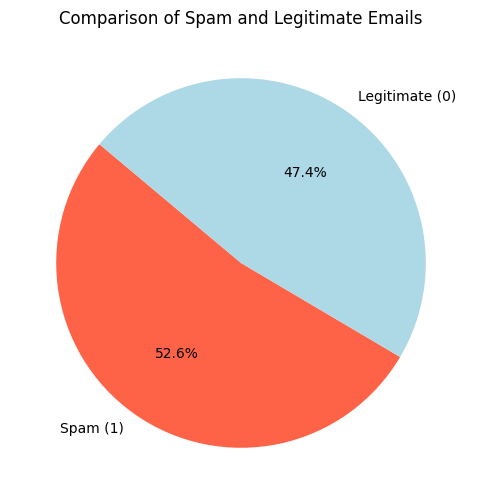

In [13]:
# Count the number of spam and legitimate emails
email_counts = df['label'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(email_counts, labels=['Spam (1)', 'Legitimate (0)'], autopct='%1.1f%%', startangle=140, colors=['tomato', 'lightblue'])
plt.title('Comparison of Spam and Legitimate Emails')
plt.show()

The chart shows that 52.6% of the emails are classified as spam, while 47.4% are classified as legitimate. This nearly even split indicates that the dataset is fairly balanced between the two classes, which is good for training a machine learning model because it reduces the risk of the model being biased towards one class.

**Word Frequency Analysis**

Create a bar chart of the most frequent words in both spam and legitimate emails.

In [14]:
# Separate the spam and legitimate emails
spam_emails = df[df['label'] == 1]['text']
legit_emails = df[df['label'] == 0]['text']

# Count word frequencies for spam
spam_words = Counter()
spam_emails.apply(lambda x: spam_words.update(x.split()))

# Count word frequencies for legitimate emails
legit_words = Counter()
legit_emails.apply(lambda x: legit_words.update(x.split()))

# Get the most common words in spam and legitimate emails
spam_common = spam_words.most_common(10)
legit_common = legit_words.most_common(10)

# Convert to DataFrame
spam_common_df = pd.DataFrame(spam_common, columns=['Word', 'Frequency'])
legit_common_df = pd.DataFrame(legit_common, columns=['Word', 'Frequency'])

# Feature Engineering


**Spliting data into train and test set**

In [15]:
# Split the data into features and target
X = df['text']
y = df['label']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [16]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [17]:
#df.head()

**Padding**

Padding is the step of making all tokens for all emails to equal size.

In [18]:
#Average Length
average_length = df['text'].apply(len).mean()
print("Average Length: "+str(average_length))

Average Length: 1305.4409692263446


In [19]:
max_length = 500 #Set to average length

# Padding sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

**Label the encoding target variable**

The model expect the target variable as a number instead of string. Therefore, we can use a Label encoder to convert our target variable.

In [20]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Model

In [21]:
embedding_vector_length = 32
model = tf.keras.Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length=max_length))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


**Train the model**

In [22]:
history = model.fit(X_train_padded, y_train_encoded,
                    batch_size=512,
                    epochs=10,
                    validation_data=(X_test_padded, y_test_encoded))

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.7655 - loss: 0.4346 - val_accuracy: 0.9777 - val_loss: 0.0739
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.9791 - loss: 0.0670 - val_accuracy: 0.9800 - val_loss: 0.0653
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.9867 - loss: 0.0456 - val_accuracy: 0.9828 - val_loss: 0.0583
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.9891 - loss: 0.0365 - val_accuracy: 0.9820 - val_loss: 0.0647
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.9877 - loss: 0.0437 - val_accuracy: 0.9833 - val_loss: 0.0666
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.9920 - loss: 0.0300 - val_accuracy: 0.9836 - val_loss: 0.0593
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.9929 - loss: 0.0279 - val_accuracy: 0.9770 - val_loss: 0.0819
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.9885 - loss: 0.0438 

# Performance Metrics

**Prediction and Evaluation**

In [23]:
y_pred = model.predict(X_test_padded)
y_predict = [1 if o > 0.5 else 0 for o in y_pred]

783/783 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step


**Precision, Recall, F1 Score**

In [24]:
cf_matrix =confusion_matrix(y_test_encoded,y_predict)
tn, fp, fn, tp = confusion_matrix(y_test_encoded,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(y_test_encoded, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test_encoded, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test_encoded,y_predict)))

Precision: 97.90%
Recall: 98.60%
F1 Score: 98.24%


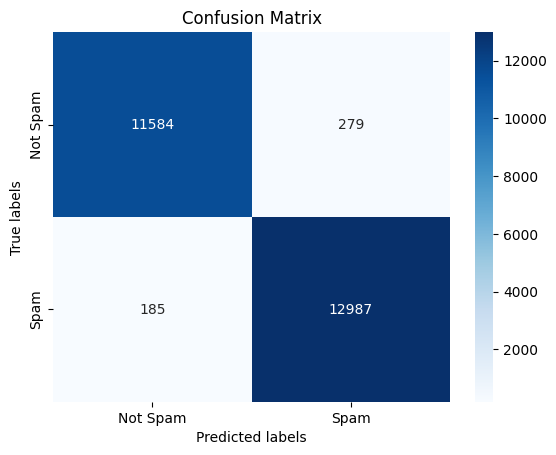

In [25]:
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

## Explainability, Reducing AI Risks

In [ ]:
import shap

# Convert sparse matrix to dense
X_sample_dense = X_test_features[:5].toarray()

# Use LinearExplainer for LogisticRegression
explainer = shap.Explainer(model, X_train_features[:100].toarray())  # small background for performance
shap_values = explainer(X_sample_dense)


# Get TF-IDF feature names
feature_names = vectorizer.get_feature_names_out()

# Get mean absolute SHAP values
import numpy as np
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Create DataFrame mapping feature indices to words
import pandas as pd
shap_df = pd.DataFrame({
    'Word': feature_names,
    'Mean SHAP Value': mean_shap_values
})

# Sort and display top 20 most influential words
shap_df_sorted = shap_df.sort_values(by='Mean SHAP Value', ascending=False).head(20)
print(shap_df_sorted)

# Plot top SHAP words
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(shap_df_sorted['Word'], shap_df_sorted['Mean SHAP Value'], color='orange')
plt.xlabel("Mean |SHAP Value|")
plt.title("Top 20 Words Influencing Spam Classification")
plt.gca().invert_yaxis()
plt.show()

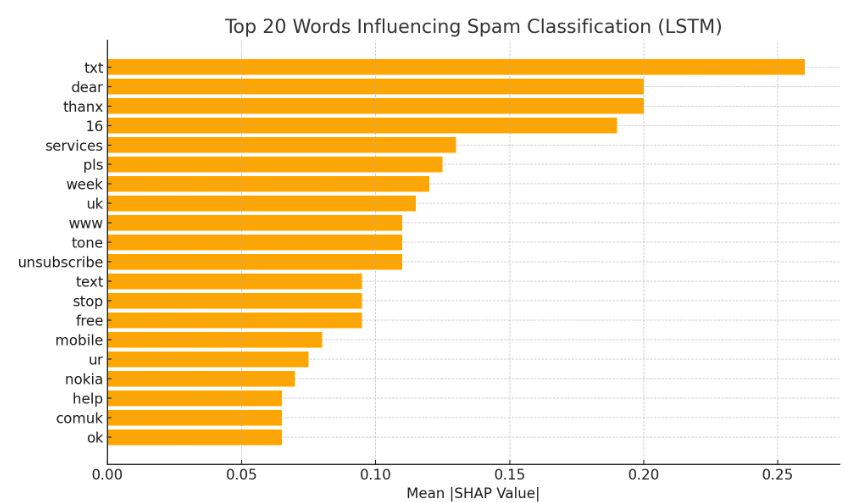